In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpi4py import MPI
from ipywidgets import interact
import os
import time
from nemesispy.common.constants import ATM, G, AU, R_SUN, R_EAR_E, M_EAR, K_B, R_JUP_E, M_JUP
from nemesispy.common.info_mol_id import mol_id
from nemesispy.radtran.forward_model import ForwardModel
from nemesispy.radtran.calc_mmw import calc_mmw
from nemesispy.models.TP_profiles import TP_Line
from nemesispy.models.gas_profiles import gen_vmr_bg
from nemesispy.radtran.calc_planck import calc_planck
from scipy import special
sns.set_style('ticks')
colors = ['#817', '#a35', '#c66', '#e94', '#ed0', '#9d5', '#4d8', '#2cb', '#0bc', '#09c', '#36b', '#639']
sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.5333333333333333, 0.06666666666666667, 0.4666666666666667),
 (0.6666666666666666, 0.2, 0.3333333333333333),
 (0.8, 0.4, 0.4),
 (0.9333333333333333, 0.6, 0.26666666666666666),
 (0.9333333333333333, 0.8666666666666667, 0.0),
 (0.6, 0.8666666666666667, 0.3333333333333333),
 (0.26666666666666666, 0.8666666666666667, 0.5333333333333333),
 (0.13333333333333333, 0.8, 0.7333333333333333),
 (0.0, 0.7333333333333333, 0.8),
 (0.0, 0.6, 0.8),
 (0.2, 0.4, 0.7333333333333333),
 (0.4, 0.2, 0.6)]

In [106]:
# Spectrally active gases to include
gas_names_active = ['H2O', 'CO2', 'CO', 'NH3', 'CH4', 'SO2', 'HCN', 'C2H2']
# Spectrally inactive gases to include
# N2 not included in this notebook
gas_names_inactive = ['N2']

gas_id = [mol_id[gas] for gas in gas_names_active] + [mol_id[gas] for gas in gas_names_inactive]
gas_id = np.array(gas_id)
iso_id = np.zeros_like(gas_id)

lowres_file_paths = [f'{gas}_flatline.kta' for gas in gas_names_active]
# $nemesispy_dir is top level nemesispy directory folder's path
__location__ = '/home/p/penn/jupyter/nemesispy_agni/'
ktable_path = os.path.join(__location__, "nemesispy/data/ktables")
for ipath,path in enumerate(lowres_file_paths):
    lowres_file_paths[ipath] = os.path.join(ktable_path,path)
cia_folder_path = os.path.join(__location__ , "nemesispy/data/cia")
cia_file_path = os.path.join(cia_folder_path,'exocia_hitran12_200-3800K.tab')
gas_id

array([ 1,  2,  5, 11,  6,  9, 23, 26, 22])

In [107]:
FM = ForwardModel()
FM.set_opacity_data(kta_file_paths=lowres_file_paths, cia_file_path=cia_file_path)

In [184]:
n_plevels = 100
NLAYER = n_plevels
P = np.logspace(1, -7, n_plevels) * ATM # in Pa
print(f'Bottom of atmosphere 3 pressures:{P[:3]/ATM} Atm')
print(f'Top of atmosphere 3 pressures:{P[-3:]/ATM} Atm')

Bottom of atmosphere 3 pressures:[10.          8.30217568  6.8926121 ] Atm
Top of atmosphere 3 pressures:[1.45082878e-07 1.20450354e-07 1.00000000e-07] Atm


In [185]:
# L98-59 d
R_star = 0.303 * R_SUN # m M3V star, 80 day rotation period, >0.8 Gyr
M_plt = 1.94 * M_EAR # kg
log_g = 4.86 # cgs
fe_h = -0.46 # dex
R_plt = 1.521 * R_EAR_E # m
SMA = 0.0486 * AU # m
T_star = 3415.0 # K
g_plt = G * M_plt / R_plt**2
T_eq = T_star * (R_star/(2*SMA))**0.5
T_int = 200.0 # randomly set

In [186]:
gases = np.array([-3.0, -4.0, -3.0, -4.0, -2.0, -3.0, -8.0, -6.0])
vmr = gen_vmr_bg(NLAYER, gases)
vmr[0]

array([1.0000000e-03, 1.0000000e-04, 1.0000000e-03, 1.0000000e-04,
       1.0000000e-02, 1.0000000e-03, 1.0000000e-08, 1.0000000e-06,
       9.8679899e-01])

In [187]:
FM.set_planet_model(M_plt=M_plt, R_plt=R_plt, R_star=R_star, gas_id_list=gas_id,
                iso_id_list=iso_id, NLAYER=NLAYER)

In [188]:
# T = T_eq * np.ones_like(P)
T = 2000.0* np.ones_like(P)


In [229]:
FM.set_phase_function(mean_size = 1.6, 
                       size_variance = 0.3, 
                       n_imag = np.ones(10)*0.01, 
                       n_imag_wave_grid = np.linspace(FM.wave_grid.min(),FM.wave_grid.max(),10), 
                       n_real_reference = 1.7,
                   n_real_reference_wave = None, normalising_wave = None, ispace=1)

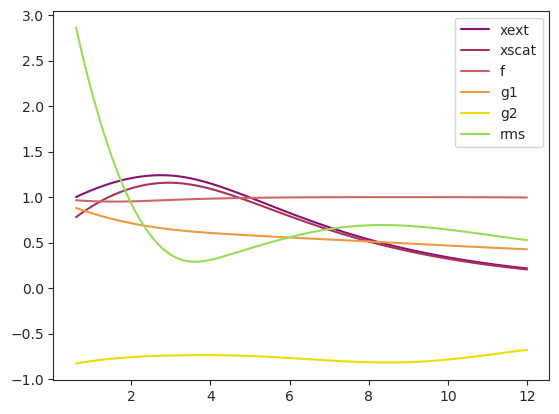

In [230]:
plt.plot(FM.wave_grid,FM.phase_func[0])
plt.legend(['xext','xscat','f','g1','g2','rms'])

In [231]:
from time import time

A = np.zeros_like(P)[:,None]
A[25:35,0] = 1e-1

toc = time()
model = FM.calc_point_spectrum_hydro(P, T, vmr, angles=np.array([0.0,0.0,180]),A_model = A*0)
tic = time()
print(f'Ran in {tic-toc}s')

toc = time()
model_aero = FM.calc_point_spectrum_hydro(P, T, vmr, angles=np.array([0.0,0.0,180]),A_model = A)
tic = time()
print(f'Ran in {tic-toc}s')

wv = FM.wave_grid
# wasp43_spec = np.array([3.341320e+25, 3.215455e+25, 3.101460e+25, 2.987110e+25,
#        2.843440e+25, 2.738320e+25, 2.679875e+25, 2.598525e+25,
#        2.505735e+25, 2.452230e+25, 2.391140e+25, 2.345905e+25,
#        2.283720e+25, 2.203690e+25, 2.136015e+25, 1.234010e+24,
#        4.422200e+23])
# spec = FM.calc_disc_spectrum_uniform(3,P,T,vmr,solspec=wasp43_spec)

Ran in 1.3208110332489014s
Ran in 4.439612150192261s


In [232]:
emis = model * 4 * np.pi**2 * R_plt**2 / R_star**2
emis_aero = model_aero * 4 * np.pi**2 * R_plt**2 / R_star**2

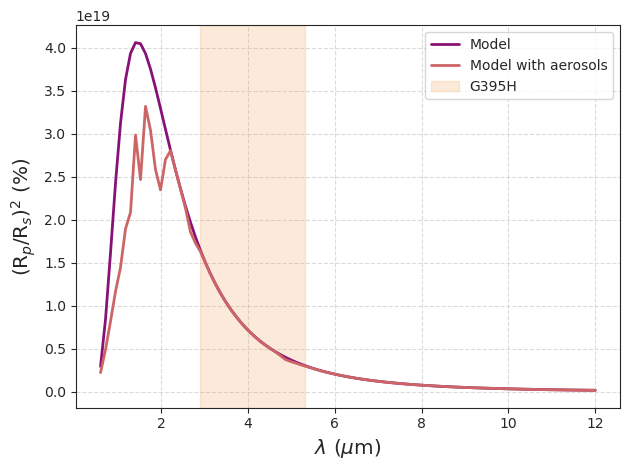

In [233]:
fig, ax = plt.subplots()
plt.plot(wv, emis, color=colors[0], linewidth=2, label='Model')
plt.plot(wv, emis_aero, color=colors[2], linewidth=2, label='Model with aerosols')
plt.axvspan(2.9, 5.3, alpha=0.2, color=colors[3], label='G395H')
plt.xlabel('$\lambda$ ($\mu$m)', size='x-large')
plt.ylabel('(R$_p$/R$_s$)$^2$ (%)', size='x-large')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()